Homework 5: Stereo
==================

In this homework, you will implement an two-view stereo algorithm. Given two images from a stereo rig, you can estimate the 3D depth of the scene by first calculating the disparity between pixels, and use the camera intrinsics to triangulate the depth. This homework will focus only on estimating the disparity between pixels.

You will estimate two stereo algorithms, which are both worth 50 points. In the first stereo algorithm, you should implement a greedy matching approach. In the second stereo algorithm, you should implement a stereo algorithm that incorporates a prior of spatial smoothness, which you optimize with dynamic programming.

But, before we begin, let's load some helper functions.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from scipy.signal import convolve2d
from math import *
from tqdm import tqdm
import time
plt.rcParams['figure.figsize'] = [7, 7]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

Visualizing Stereo Pairs
------------------------

Let's visualize the images captured by the left and right camera pair. These images from the Middlebury Stereo Dataset (http://vision.middlebury.edu/stereo/data/). 

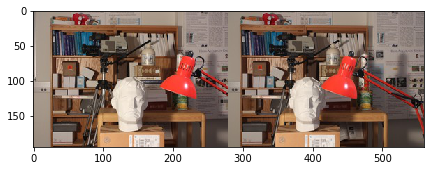

In [10]:
left = load_image('im0.jpg')
right = load_image('im1.jpg')

height,width,_ = left.shape

pad_size = 50

left_pad = np.pad(left, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant')
right_pad = np.pad(right, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant')

show_image(np.concatenate([left, right], axis=1))

Problem 1: Greedy Stereo Matching (50 points)
---------------------------------------------

From the left and right image, calculate the disparity between each pixel using a greedy matching algorithm. You may assume that the stereo pairs are rectified, which means the camera pairs are only horizontally translated. In your PDF, be sure to include both the code and the visualization of the estimated disparity. 

**Distance Function**: There are a variety of distance functions that you can use. For this problem, you can just use sum of squared differences between RGB patches.

**Accuracy**: It is very hard to get the right result with a greedy approach. However, your approach should at least put the head and background in right place. 

[-30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13
 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30]


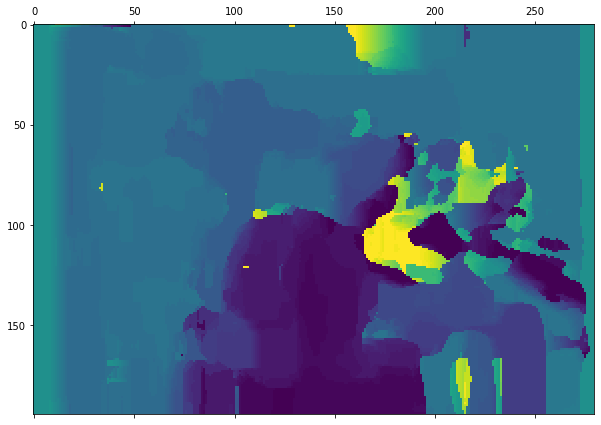

In [16]:
# Some variables that might help you. But you don't have to use them.
max_dx = 30 # max number of displacements to search. make this smaller to speed up
dxs = np.linspace(-max_dx, max_dx, num=2*max_dx+1).astype("int32")
win_size = 8 # size of window you use for ssd computation
print(dxs)
def compute_disparity():
    # TODO: calculate the disparity using a greedy approach between left and right
        # TODO: calculate the disparity using a greedy approach between left and right
    res = np.zeros((height,width))
    for i in range(height):
        i_pad = i+ pad_size
        for j in range(width):
            j_pad = j + pad_size
            window_left = np.array(left_pad[i_pad-win_size:i_pad+win_size,j_pad-win_size:j_pad+win_size])
            best_ssd = 1000000
            for x in dxs:
                j_pad_offset = j_pad + x
                window_right = np.array(right_pad[i_pad-win_size:i_pad+win_size,j_pad_offset-win_size:j_pad_offset+win_size])
                ssd = np.sum((window_left - window_right)**2)
                if ssd<best_ssd:
                    res[i,j] = x
                    best_ssd = ssd
    return res

disparity = compute_disparity()
plt.matshow(disparity)

Problem 2: Dynamic Programming (50 points)
------------------------------------------

In this problem, implement a dynamic programming based stereo estimation algorithm that incorporates the spatial smoothness between adjacent disparities. For the local matching cost, you can use the same sum-of-squared-differences as above. For the pairwise cost, you can use L1 distance. In your PDF, include both code and the estimated disparity map.

**Hint**: In your algorithms course, you should have covered the Viterbi algorithm. Apply it to this problem. Write out the objective function as a recursive function. As you compute the recurrence, keep track of the pointers to the previous iteration. After you finish the recursive computation, just walk backwards using the stored pointers.

**Hint Two**: To help you debug, you can change the strength of the pairwise term. If you turn off the pairwise term, your implementation should recover the same solution as the greedy approach. If you make the strength of the pairwise term very high, your implementation should assign pixels to be identical disparity.

**Accuracy**: It is OK if you do not get perfect stereo reconstruction. Carl's solution gets it mostly right except for the lamp, which fails due to specular reflection. 

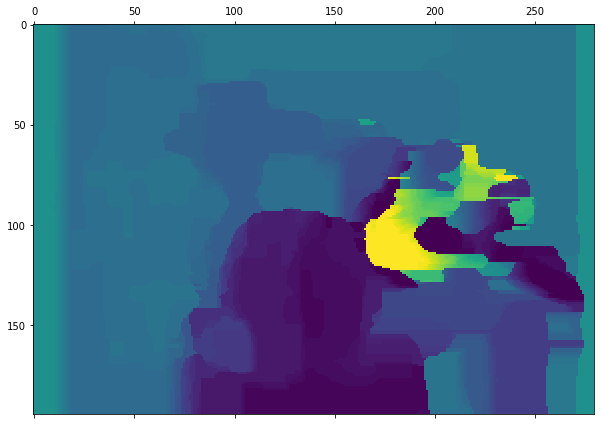

In [25]:
# Some variables that might help you. But you don't have to use them.
max_dx = 30 # max number of displacements to search. make this smaller to speed up
dxs = np.linspace(-max_dx, max_dx, num=2*max_dx+1).astype("int32")

win_size = 10 # size of window you use for ssd computation
lamb_coeff = 1 # coefficient in front of pairwise cost

def l1_score(a,b):
    # TODO: implement a score for L1 distance
    return abs(a-b)

def compute_disparity():
    # TODO: calculate the disparity using dynamic programming between left and right
    res = np.zeros((height,width))
    d = np.zeros((height,width))
    d_x_map = np.zeros((2*max_dx+1,width))
    dp = np.zeros(2*max_dx+1)
    dp_parent = np.zeros((2*max_dx+1,width))
    for i in range(height):
        i_pad = i+ pad_size
        for j in range(width):
            j_pad = j + pad_size
            window_left = np.array(left_pad[i_pad-win_size:i_pad+win_size,j_pad-win_size:j_pad+win_size])
            best_ssd = 1000000
            for x in dxs:
                j_pad_offset = j_pad + x
                window_right = np.array(right_pad[i_pad-win_size:i_pad+win_size,j_pad_offset-win_size:j_pad_offset+win_size])
                ssd = np.sum((window_left - window_right)**2)
                d_x_map[x+max_dx,j] = ssd
        for col in range(1,width):
            for dx in range(2*max_dx+1):
                for k in range(2*max_dx+1):
                    dp[k] = d_x_map[dx,col] + d_x_map[k,col-1]+ lamb_coeff*l1_score(k,dx)
                min_index = np.argmin(dp)
                dp_parent[dx,col] = min_index
                d_x_map[dx,col] = dp[min_index]
        min_cost = np.argmin(d_x_map[:,-1])
        res[i,-1] = min_index - max_dx
        for row in range(width-2,-1,-1):
            res[i,row] = dp_parent[int(res[i,row+1]+ max_dx),row+1] - max_dx
                
                
                
    return res

disparity = compute_disparity()
plt.matshow(disparity)

Deliverables
------------

Export your completed notebook as a PDF. Make sure the PDF includes both the code and the resulting output. We will be grading both your code and final output. (Runtime will not impact your score.)